In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm #para poder ver las barritas de % cargandose cuando va iterando
from PIL import Image as im

#PyTorch
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

#Optuna
import optuna
from optuna.integration import PyTorchLightningPruningCallback

In [2]:
#Para usar solo 24 cores que me dijo NW

torch.set_num_threads(24)

In [ ]:
# Function to save the model 
def saveModel(model): 
    path = "./Modelos_Fiteados/CLASIF/360salidas.pth" 
    torch.save(model.state_dict(), path)

In [3]:
datatrain = torchvision.datasets.MNIST('./', train=True, download=True)
datatest = torchvision.datasets.MNIST('./', train=False, download=True)

m=len(datatrain)

train_data, val_data = random_split(datatrain, [int(m-m*0.2), int(m*0.2)])

In [4]:
X_train = [x[0] for x in train_data]
y_train = [x[1] for x in train_data]

X_val = [x[0] for x in val_data]
y_val = [x[1] for x in val_data]

X_test = [x[0] for x in datatest]
y_test = [x[1] for x in datatest]

In [5]:
RX_train = [0]*(20*len(X_train))
RY_train = [0]*(20*len(X_train))

RX_val = [0]*(20*len(X_val))
RY_val = [0]*(20*len(X_val))

RX_test = [0]*(20*len(X_test))
RY_test = [0]*(20*len(X_test))

In [6]:
rotador = torchvision.transforms.functional.rotate

In [7]:
for i in range(len(X_train)):
    for j in range(20):
        ang = np.random.randint(0,359)
        RX_train[i*20+j]=rotador(X_train[i],ang)
        RY_train[i*20+j]= ang
        
for i in range(len(X_val)):
    for j in range(20):
        ang = np.random.randint(0,359)
        RX_val[i*20+j]=rotador(X_val[i],ang)
        RY_val[i*20+j]= ang
        
        
for i in range(len(X_test)):
    for j in range(20):
        ang = np.random.randint(0,359)
        RX_test[i*20+j]=rotador(X_test[i],ang)
        RY_test[i*20+j]= ang

In [ ]:
# print(RY_test)

In [8]:
to_tensor = torchvision.transforms.ToTensor()

In [9]:
tensor_RX_train = [to_tensor(RX_train[i]).unsqueeze(0) for i in range(len(RX_train))]
tensor_RX_train = torch.cat(tensor_RX_train)

tensor_RY_train = torch.Tensor(RY_train).long()

######

tensor_RX_val = [to_tensor(RX_val[i]).unsqueeze(0) for i in range(len(RX_val))]
tensor_RX_val = torch.cat(tensor_RX_val)

tensor_RY_val = torch.Tensor(RY_val).long()

######

tensor_RX_test = [to_tensor(RX_test[i]).unsqueeze(0) for i in range(len(RX_test))]
tensor_RX_test = torch.cat(tensor_RX_test)

tensor_RY_test = torch.Tensor(RY_test).long()

In [10]:
tensor_datatrain = TensorDataset(tensor_RX_train, tensor_RY_train)
train_loader = DataLoader(tensor_datatrain, batch_size=5000, shuffle=True)

tensor_dataval = TensorDataset(tensor_RX_val, tensor_RY_val)
valid_loader = DataLoader(tensor_dataval, batch_size=5000, shuffle=True)

tensor_datatest = TensorDataset(tensor_RX_test, tensor_RY_test)
test_loader = DataLoader(tensor_datatest, batch_size=1)

In [11]:
class Net(nn.Module):    
    def __init__(self,nf):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, nf, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(nf, nf, 3)
        self.fc1 = nn.Linear(nf*12*12, 1024)
        self.fc2 = nn.Linear(1024, 360)
        self.drop = nn.Dropout(0.25)
        self.soft = nn.Softmax()

    def forward(self, x):
        # Apply net
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

## Entrenamiento

In [12]:
nf=64
CLASIF = Net(nf)

#Definimos la loss function
loss_fn = nn.CrossEntropyLoss()
# Definimos el optimizador
optimizer = torch.optim.Adam(CLASIF.parameters(), lr=0.001, weight_decay=0.0001 )

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
CLASIF.to(device)


Selected device: cpu


Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=360, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (soft): Softmax(dim=None)
)

In [13]:
### Training function
def train_epoch(CLASIF, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    CLASIF.train()
    train_loss = []
    # Iterate the dataloader
    for image_batch, label in dataloader: 
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        label = label.to(device)
        #utputs
        decoded_data = CLASIF.forward(image_batch)
        # Evaluate loss
        loss = loss_fn(decoded_data, label)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())
        
    return np.mean(train_loss)

In [14]:
### Testing function
def test_epoch(CLASIF, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    CLASIF.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # output
            decoded_data = CLASIF.forward(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(label.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def early_stopping(train_loss, validation_loss, min_delta, tolerance):

    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter[0] +=1
        if counter >= tolerance:
            return True

In [15]:
num_epochs = 30
diz_loss = {'train_loss_1':[], 'train_loss_2':[], 'val_loss':[]}
for epoch in tqdm(range(num_epochs)):
    train_loss_1 =train_epoch(CLASIF,
                             device,
                            train_loader,
                            loss_fn,
                            optimizer)
    train_loss_2 = test_epoch(CLASIF,
                          device,
                          train_loader,
                          loss_fn)
    val_loss = test_epoch(CLASIF,
                          device,
                          valid_loader,
                          loss_fn)
    print('\n EPOCH {}/{} \t train loss_1 {} \t train loss_2 {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss_1,train_loss_2,val_loss))
    diz_loss['train_loss_1'].append(train_loss_1)
    diz_loss['train_loss_2'].append(train_loss_2)
    diz_loss['val_loss'].append(val_loss)
#     plot_ae_outputs(AEC, n=10)

# # early stopping
#     if early_stopping(train_loss, val_loss, min_delta=0.001, tolerance = 5):
#       print("We are at epoch:", i)
#       break

  3%|██▌                                                                           | 1/30 [05:49<2:48:50, 349.32s/it]


 EPOCH 1/30 	 train loss_1 3.6426429748535156 	 train loss_2 1.5296937227249146 	 val loss 1.5685231685638428


  7%|█████▏                                                                        | 2/30 [11:38<2:42:55, 349.14s/it]


 EPOCH 2/30 	 train loss_1 1.0665861368179321 	 train loss_2 0.4079921543598175 	 val loss 0.44010230898857117


 10%|███████▊                                                                      | 3/30 [17:27<2:37:05, 349.09s/it]


 EPOCH 3/30 	 train loss_1 0.5530864000320435 	 train loss_2 0.2584906220436096 	 val loss 0.2912296950817108


 13%|██████████▍                                                                   | 4/30 [23:15<2:31:10, 348.86s/it]


 EPOCH 4/30 	 train loss_1 0.421066552400589 	 train loss_2 0.2094358503818512 	 val loss 0.24408911168575287


 17%|█████████████                                                                 | 5/30 [29:04<2:25:15, 348.60s/it]


 EPOCH 5/30 	 train loss_1 0.3581044375896454 	 train loss_2 0.18384039402008057 	 val loss 0.2204175591468811


 20%|███████████████▌                                                              | 6/30 [34:51<2:19:21, 348.39s/it]


 EPOCH 6/30 	 train loss_1 0.3215969502925873 	 train loss_2 0.16637860238552094 	 val loss 0.2044098973274231


 23%|██████████████████▏                                                           | 7/30 [40:40<2:13:30, 348.28s/it]


 EPOCH 7/30 	 train loss_1 0.29558828473091125 	 train loss_2 0.15445303916931152 	 val loss 0.1928345412015915


 27%|████████████████████▊                                                         | 8/30 [46:27<2:07:38, 348.10s/it]


 EPOCH 8/30 	 train loss_1 0.2788691520690918 	 train loss_2 0.14727512001991272 	 val loss 0.18732307851314545


 30%|███████████████████████▍                                                      | 9/30 [52:15<2:01:49, 348.08s/it]


 EPOCH 9/30 	 train loss_1 0.2651923596858978 	 train loss_2 0.1433723419904709 	 val loss 0.18423490226268768


 33%|█████████████████████████▋                                                   | 10/30 [58:03<1:55:59, 347.96s/it]


 EPOCH 10/30 	 train loss_1 0.2529190480709076 	 train loss_2 0.13549412786960602 	 val loss 0.1757502555847168


 37%|███████████████████████████▍                                               | 11/30 [1:03:51<1:50:09, 347.88s/it]


 EPOCH 11/30 	 train loss_1 0.24550604820251465 	 train loss_2 0.13033802807331085 	 val loss 0.17241907119750977


 40%|██████████████████████████████                                             | 12/30 [1:09:38<1:44:20, 347.81s/it]


 EPOCH 12/30 	 train loss_1 0.2375950664281845 	 train loss_2 0.13101790845394135 	 val loss 0.1747082620859146


 43%|████████████████████████████████▌                                          | 13/30 [1:15:26<1:38:32, 347.78s/it]


 EPOCH 13/30 	 train loss_1 0.2314566820859909 	 train loss_2 0.1256030797958374 	 val loss 0.16914749145507812


 47%|███████████████████████████████████                                        | 14/30 [1:21:13<1:32:42, 347.64s/it]


 EPOCH 14/30 	 train loss_1 0.2265269160270691 	 train loss_2 0.12404467165470123 	 val loss 0.16776719689369202


 50%|█████████████████████████████████████▌                                     | 15/30 [1:27:01<1:26:55, 347.72s/it]


 EPOCH 15/30 	 train loss_1 0.22155706584453583 	 train loss_2 0.12090098112821579 	 val loss 0.16596142947673798


 53%|████████████████████████████████████████                                   | 16/30 [1:32:49<1:21:07, 347.65s/it]


 EPOCH 16/30 	 train loss_1 0.2170974761247635 	 train loss_2 0.11828596889972687 	 val loss 0.16414839029312134


 57%|██████████████████████████████████████████▌                                | 17/30 [1:38:36<1:15:18, 347.57s/it]


 EPOCH 17/30 	 train loss_1 0.21273933351039886 	 train loss_2 0.11781660467386246 	 val loss 0.16519787907600403


 60%|█████████████████████████████████████████████                              | 18/30 [1:44:23<1:09:29, 347.46s/it]


 EPOCH 18/30 	 train loss_1 0.2100573033094406 	 train loss_2 0.11474303156137466 	 val loss 0.16223278641700745


 63%|███████████████████████████████████████████████▌                           | 19/30 [1:50:11<1:03:41, 347.42s/it]


 EPOCH 19/30 	 train loss_1 0.206887885928154 	 train loss_2 0.11367134749889374 	 val loss 0.16116108000278473


 67%|███████████████████████████████████████████████████▎                         | 20/30 [1:55:59<57:58, 347.81s/it]


 EPOCH 20/30 	 train loss_1 0.20406006276607513 	 train loss_2 0.11089306324720383 	 val loss 0.15764214098453522


 70%|█████████████████████████████████████████████████████▉                       | 21/30 [2:01:52<52:23, 349.24s/it]


 EPOCH 21/30 	 train loss_1 0.20189166069030762 	 train loss_2 0.11278355866670609 	 val loss 0.16113561391830444


 73%|████████████████████████████████████████████████████████▍                    | 22/30 [2:07:44<46:41, 350.21s/it]


 EPOCH 22/30 	 train loss_1 0.1982402205467224 	 train loss_2 0.1118159294128418 	 val loss 0.16053372621536255


 77%|███████████████████████████████████████████████████████████                  | 23/30 [2:13:37<40:55, 350.85s/it]


 EPOCH 23/30 	 train loss_1 0.19495217502117157 	 train loss_2 0.10944678634405136 	 val loss 0.1590849906206131


 80%|█████████████████████████████████████████████████████████████▌               | 24/30 [2:19:29<35:07, 351.28s/it]


 EPOCH 24/30 	 train loss_1 0.19468240439891815 	 train loss_2 0.10753392428159714 	 val loss 0.15733003616333008


 83%|████████████████████████████████████████████████████████████████▏            | 25/30 [2:25:21<29:17, 351.54s/it]


 EPOCH 25/30 	 train loss_1 0.1915072649717331 	 train loss_2 0.10689586400985718 	 val loss 0.15831072628498077


 87%|██████████████████████████████████████████████████████████████████▋          | 26/30 [2:31:14<23:27, 351.79s/it]


 EPOCH 26/30 	 train loss_1 0.19007371366024017 	 train loss_2 0.10441309958696365 	 val loss 0.1554991751909256


 90%|█████████████████████████████████████████████████████████████████████▎       | 27/30 [2:37:06<17:36, 352.11s/it]


 EPOCH 27/30 	 train loss_1 0.18699724972248077 	 train loss_2 0.10304107517004013 	 val loss 0.15398572385311127


 93%|███████████████████████████████████████████████████████████████████████▊     | 28/30 [2:42:58<11:43, 351.80s/it]


 EPOCH 28/30 	 train loss_1 0.18596147000789642 	 train loss_2 0.10196805000305176 	 val loss 0.15335923433303833


 97%|██████████████████████████████████████████████████████████████████████████▍  | 29/30 [2:48:48<05:51, 351.44s/it]


 EPOCH 29/30 	 train loss_1 0.1842392086982727 	 train loss_2 0.10294345021247864 	 val loss 0.1545894891023636


100%|█████████████████████████████████████████████████████████████████████████████| 30/30 [2:54:39<00:00, 349.31s/it]


 EPOCH 30/30 	 train loss_1 0.1832636594772339 	 train loss_2 0.10122878104448318 	 val loss 0.15398947894573212


In [ ]:
saveModel(CLASIF)

In [ ]:
CLASIF.load_state_dict(torch.load("./Modelos_Fiteados/CLASIF/360salidas.pth"))

In [16]:
np.savetxt('./Modelos_Fiteados/losses/CLASIF/Nuevas_loss/errorTest_360_1',diz_loss['train_loss_1'])
np.savetxt('./Modelos_Fiteados/losses/CLASIF/Nuevas_loss/errorTest_360_2',diz_loss['train_loss_2'])
np.savetxt('./Modelos_Fiteados/losses/AEC/Nuevas_loss/errorVal_360',diz_loss['val_loss'])

# train_coso = np.loadtxt('./Modelos_Fiteados/losses/CLASIF/test_360salidas')
# val_coso = np.loadtxt('./Modelos_Fiteados/losses/AEC/val_360salidas')

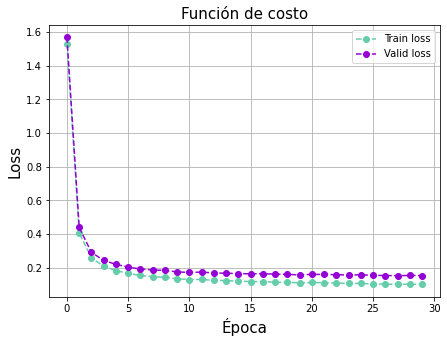

In [17]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.plot(diz_loss['train_loss_2'], linestyle='--', marker='o',  label='Train loss', c='mediumaquamarine')
plt.plot(diz_loss['val_loss'], linestyle='--', marker='o', label='Valid loss', c='darkviolet')
plt.xlabel('Época',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Función de costo",fontsize=15)
plt.grid()
plt.legend()
plt.savefig('./Modelos_Fiteados/Imagenes/CLASIF/errores_360.png', format='png')
plt.show()

### Veamos la matriz de confusion y metricas

In [ ]:
test_acc = 0

y_test=[]
y_pred=[]
label=[]
pred=[]

CLASIF.to(device)

with torch.no_grad():
    for x_batched, y_batched in test_loader:
        # Move data to device
        x_batched = x_batched.to(device)
        y_batched = y_batched.to(device)
        
#         print('blabla')

        # forward the data
        out = CLASIF.forward(x_batched)

        y_test = (y_batched.detach().cpu().numpy())
        y_pred = (np.argmax(out.detach().cpu().numpy(), axis = 1))
        label.extend(y_test)
        pred.extend(y_pred)
        
        right = np.sum(y_pred == y_test)
        test_acc = test_acc + right

print(f"The obtained accuracy is {test_acc/len(RY_test)*100} %")

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(label, pred, marker=".", s=5, alpha=.2, c='blueviolet')
# plt.plot(np.linspace(3,360, num=100),np.linspace(0,360, num=100), linestyle='--', c='orange')
plt.xlabel('Valor REAL',fontsize=15)
plt.ylabel('Valor PREDICHO',fontsize=15)
plt.title("Dispersión de valores predichos",fontsize=15)
plt.grid()
plt.savefig('./Modelos_Fiteados/Imagenes/CLASIF/disper_360salidas.png', format='png')
plt.show()

In [ ]:
def confussion_plot(real, prediction):
    categories = ['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4']

    array = confusion_matrix(real, prediction, normalize="true")
    df_cm = pd.DataFrame(array, index = [i for i in categories], columns = [i for i in categories])
    
    fig = plt.figure(figsize=(8,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='viridis')
    plt.ylabel("Labels",fontsize=15)
    plt.xlabel("Prediccion",fontsize=15)
    plt.title("Matríz de Confusión",fontsize=15)
    plt.savefig('./Modelos_Fiteados/Imagenes/CLASIF/CM_30_norm.png', format='png')
    plt.show()

In [ ]:
confussion_plot(label, pred)